In [1]:
import backtrader as bt
import backtrader.feeds as btfeeds
import os
import datetime
import pickle 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

/home/aj/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.0.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.setup_log_file()
        
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def setup_log_file(self):
        '''
        Function to setup log files.
        '''
        cn = self.__class__.__name__
        self.logfile ='{}-Results.csv'.format(cn)
 
        #Write the header to the trade log.
        log_header = 'Datetime,Open,High,Low,Close,Volume,Signal'
 
        with open(self.logfile, 'w') as file:
            file.write(log_header + "\n")

    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:

            if self.dataclose[0] - self.dataclose[-1] > 500:

                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()

        else:

            if self.dataclose[0] - self.dataclose[-1] < -500:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()
                
        dt = self.datas[0].datetime.datetime()
        bar = len(self.datas[0])
        o = self.datas[0].open[0]
        h = self.datas[0].high[0]
        l = self.datas[0].low[0]
        c = self.datas[0].close[0]
        v = self.datas[0].volume[0]
 
        # Create some signal Aliases so we can easily replace them with
        # better signals later
        long = self.dataclose[0] - self.dataclose[-1] > 500
        short = self.dataclose[0] - self.dataclose[-1] < -500 
 
        # This part can be left alone - Just create the long and short conditions
        # above and everything will work!
        if long:
            sig = 'Long'
        elif short:
            sig = 'Short'
        else:
            sig = 'FLAT'
 
        with open(self.logfile, 'a+') as f:
            log = "{},{},{},{},{},{},{}\n".format(dt,o,h,l,c,v,sig)
            f.write(log)

In [3]:
class BTCUSDT(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.setup_log_file()
  
    def setup_log_file(self):
        '''
        Function to setup log files.
        '''
        cn = self.__class__.__name__
        self.logfile ='{}-Bmark.csv'.format(cn)
 
        #Write the header to the trade log.
        log_header = 'Datetime,Open,High,Low,Close,Volume'
 
        with open(self.logfile, 'w') as file:
            file.write(log_header + "\n")

    def next(self):
        
        #self.log('Close, %.2f' % self.dataclose[0])
    
        dt = self.datas[0].datetime.datetime()
        bar = len(self.datas[0])
        o = self.datas[0].open[0]
        h = self.datas[0].high[0]
        l = self.datas[0].low[0]
        c = self.datas[0].close[0]
        v = self.datas[0].volume[0]
        
        with open(self.logfile, 'a+') as f:
            log = "{},{},{},{},{},{}\n".format(dt,o,h,l,c,v)
            f.write(log)

In [4]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))
    
def printSharpe(analyzer):
    SharpeRatio = analyzer.SharpeRatio
    print('SharpeRatio: {}'.format(SharpeRatio))

In [5]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
datapath = os.path.abspath(os.getcwd() + '/BTC_USDT_' + str(datetime.datetime.now().strftime("%Y_%m_%d")))

# Create Strategy Data Feed
data = btfeeds.GenericCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2018, 1, 1),
        dtformat=('%Y-%m-%d %H:%M:%S'),
        datetime=0,
        high=2,
        low=3,
        open=1,
        close=4,
        volume=5,
        openinterest=-1,
        timeframe= bt.TimeFrame.Minutes,
        compression= 30
    )

cerebro.adddata(data)
    
cerebro.broker.setcash(2000.0)

# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')

cerebro.addsizer(bt.sizers.PercentSizer, percents=20)

#cerebro.addsizer(bt.sizers.FixedSize, stake=0.05)

cerebro.broker.addcommissioninfo(CommInfoFractional())

cerebro.broker.setcommission(commission=0.005)

cerebro.broker.set_slippage_perc(perc=0.005,
                                slip_open=True, slip_limit=True,
                                slip_match=True, slip_out=False)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Balance: %.2f' % cerebro.broker.getvalue())

results1 = cerebro.run()
results0 = results1[0]
pyfoliozer = results0.analyzers.getbyname('pyfolio')

returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

print('Final Balance: %.2f' % cerebro.broker.getvalue())

Starting Balance: 2000.00
2018-01-02, BUY CREATE, 14370.00
2018-01-02, BUY EXECUTED, Price: 14441.87, Cost: 402.00, Comm 2.01
2018-01-08, SELL CREATE, 14974.37
2018-01-08, SELL EXECUTED, Price: 14899.50, Cost: 402.00, Comm 2.07
2018-01-08, OPERATION PROFIT, GROSS 12.74, NET 8.65
2018-01-08, BUY CREATE, 14323.03
2018-01-08, BUY EXECUTED, Price: 14394.65, Cost: 403.74, Comm 2.02
2018-01-10, SELL CREATE, 13300.00
2018-01-10, SELL EXECUTED, Price: 13261.35, Cost: 403.74, Comm 1.86
2018-01-10, OPERATION PROFIT, GROSS -31.79, NET -35.67
2018-01-10, BUY CREATE, 14160.00
2018-01-10, BUY EXECUTED, Price: 14230.80, Cost: 396.57, Comm 1.98
2018-01-11, SELL CREATE, 13555.31
2018-01-11, SELL EXECUTED, Price: 13462.35, Cost: 396.57, Comm 1.88
2018-01-11, OPERATION PROFIT, GROSS -21.41, NET -25.27
2018-01-11, BUY CREATE, 13108.20
2018-01-11, BUY EXECUTED, Price: 13183.58, Cost: 391.78, Comm 1.96
2018-01-12, SELL CREATE, 12733.89
2018-01-12, SELL EXECUTED, Price: 12679.76, Cost: 391.78, Comm 1.88
2018

In [6]:
# print the analyzers
printTradeAnalysis(results0.analyzers.ta.get_analysis())
printSQN(results0.analyzers.sqn.get_analysis())

Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               0              12             4              8              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               33.333333333333332              6              144.81         
SQN: 0.47


In [7]:
cerebro_bmark = bt.Cerebro()
cerebro_bmark.addstrategy(BTCUSDT)
datapath = os.path.abspath(os.getcwd() + '/BTC_USDT_' + str(datetime.datetime.now().strftime("%Y_%m_%d")))

# Create a Benchmark Data Feed
data1 = btfeeds.GenericCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2018, 1, 1),
        dtformat=('%Y-%m-%d %H:%M:%S'),
        datetime=0,
        high=2,
        low=3,
        open=1,
        close=4,
        volume=5,
        openinterest=-1,
        timeframe= bt.TimeFrame.Minutes,
        compression= 30
    )

cerebro_bmark.adddata(data1)

results11 = cerebro_bmark.run()
results00 = results11[0]

In [8]:
df_bmark = pd.read_csv('BTCUSDT-Bmark.csv', parse_dates=True, index_col=[0])
df_bmark.index = pd.to_datetime(df_bmark.index)
df_bmark.columns = ['Open','High','Low','BTCUSDT','Volume']

In [9]:
df_bmark.head()

,Open,High,Low,BTCUSDT,Volume
Datetime,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13521.12,221.752443
2018-01-01 00:30:00,13500.00,13690.87,13450.00,13529.01,221.603756
2018-01-01 01:00:00,13528.99,13595.89,13402.28,13560.00,160.399291
2018-01-01 01:30:00,13559.99,13559.99,13155.38,13203.06,223.297715
2018-01-01 02:00:00,13203.00,13411.76,13202.03,13225.00,203.728509


In [10]:
df = pd.read_csv('TestStrategy-Results.csv', parse_dates=True, index_col=[0])
df.index = pd.to_datetime(df.index)

In [11]:
df.head()

,Open,High,Low,Close,Volume,Signal
Datetime,,,,,,
2018-01-01 12:00:00,13220.56,13300.00,13056.23,13146.15,138.763677,FLAT
2018-01-01 12:30:00,13146.81,13245.55,13117.72,13172.42,121.729031,FLAT
2018-01-01 13:00:00,13150.05,13200.41,12815.70,12977.16,287.404244,FLAT
2018-01-01 13:30:00,12977.16,13104.79,12921.72,13017.00,164.496882,FLAT
2018-01-01 14:00:00,12999.71,13245.00,12750.00,12927.00,394.246119,FLAT


In [12]:
# Get long and short signal dates
longs = df[df['Signal'] == 'Long']
shorts = df[df['Signal'] == 'Short']
 
# Need to get the index values for each signal. We will use these later for
# looping and creating a new dataframe
long_entries = longs.index.values
short_entries = shorts.index.values
 
# Create two new dataframes for the results
long_analysis = pd.DataFrame()
short_analysis = pd.DataFrame()

In [13]:
def pnl_calc(x, open_value, short=False):
    '''
    open_value: Float, the close value on the day of the signal.
    short: Bool, will invert the percentage change calc for shorts
    because negative is good!
    '''
    try:
        pnl = (x - open_value) / open_value
 
        if short:
            return -pnl
        else:
            return pnl
    except ZeroDivisionError:
        return 0

In [14]:
for signal_date in long_entries:
    # This will get the close values for the 200 closes following the signal
    closes = pd.DataFrame(df['Close'].loc[signal_date:].head(200),).reset_index()
 
    # Then we calculate the difference
    closes['PNL'] = closes['Close'].apply(pnl_calc, open_value=closes['Close'].iloc[0], short=False)
    long_analysis[signal_date] = closes['PNL']

In [15]:
for signal_date in short_entries:
    closes = pd.DataFrame(df['Close'].loc[signal_date:].head(200),).reset_index()
 
    closes['PNL'] = closes['Close'].apply(pnl_calc, open_value=closes['Close'].iloc[0], short=True)
    short_analysis[signal_date] = closes['PNL']

In [16]:
# Get the average PNL
long_average = long_analysis.mean(axis=1)
short_average = short_analysis.mean(axis=1)

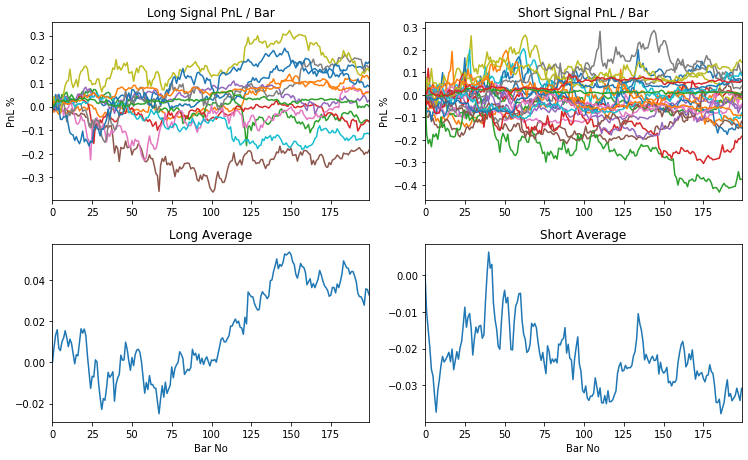

In [17]:
# Start Plotting!
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2)
 
# All long Entries
ax1 = long_analysis.plot(ax=axes[0,0], kind='line', legend=False, title='Long Signal PnL / Bar', )
ax1.set_ylabel("PnL %")
 
# All short Entries
ax2 = short_analysis.plot(ax=axes[0,1], kind='line',  legend=False, title='Short Signal PnL / Bar')
ax2.set_ylabel("PnL %")
 
# Average long Entries
ax3 = long_average.plot(ax=axes[1,0], kind='line', legend=False, title='Long Average')
ax3.set_xlabel("Bar No")
 
# Average Short Entries
ax4 = short_average.plot(ax=axes[1,1], kind='line', legend=False, title='Short Average')
ax4.set_xlabel("Bar No")
 
fig.set_size_inches(10.5, 6.5)
 
# Show the figure
plt.tight_layout()
plt.show();

In [18]:
df_bmark = df_bmark.resample('D').ffill()
bench = pd.DataFrame(df_bmark.BTCUSDT).fillna(0)
bench['Returns'] = returns.values
bench = bench.fillna(0)
bench.head()

,BTCUSDT,Returns
Datetime,,
2018-01-01,13521.12,0.000000
2018-01-02,13700.04,0.002241
2018-01-03,14835.99,0.003394
2018-01-04,14796.98,0.001938
2018-01-05,14884.99,0.026256


In [19]:
returns0 = pd.DataFrame(returns)
returns0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2018-01-01 00:00:00+00:00 to 2019-10-19 00:00:00+00:00
Data columns (total 1 columns):
return    657 non-null float64
dtypes: float64(1)
memory usage: 10.3 KB


In [20]:
bench.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2018-01-01 to 2019-10-19
Freq: D
Data columns (total 2 columns):
BTCUSDT    657 non-null float64
Returns    657 non-null float64
dtypes: float64(2)
memory usage: 15.4 KB


In [22]:
import pyfolio as pf

Start date,2018-01-01
End date,2019-10-19
Total months,31
,Backtest
Annual return,2.7%
Cumulative returns,7.2%
Annual volatility,10.2%
Sharpe ratio,0.31
Calmar ratio,0.15
Stability,0.11
Max drawdown,-18.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.33,2018-01-06,2018-12-15,2019-06-22,380
1,4.51,2019-08-08,2019-08-28,NaT,NaN
2,2.44,2019-07-20,2019-07-27,2019-08-03,10
3,0.66,2019-08-05,2019-08-06,2019-08-07,3
4,0.24,2019-07-18,2019-07-19,2019-07-20,2


Stress Events,mean,min,max
New Normal,0.01%,-2.94%,2.74%


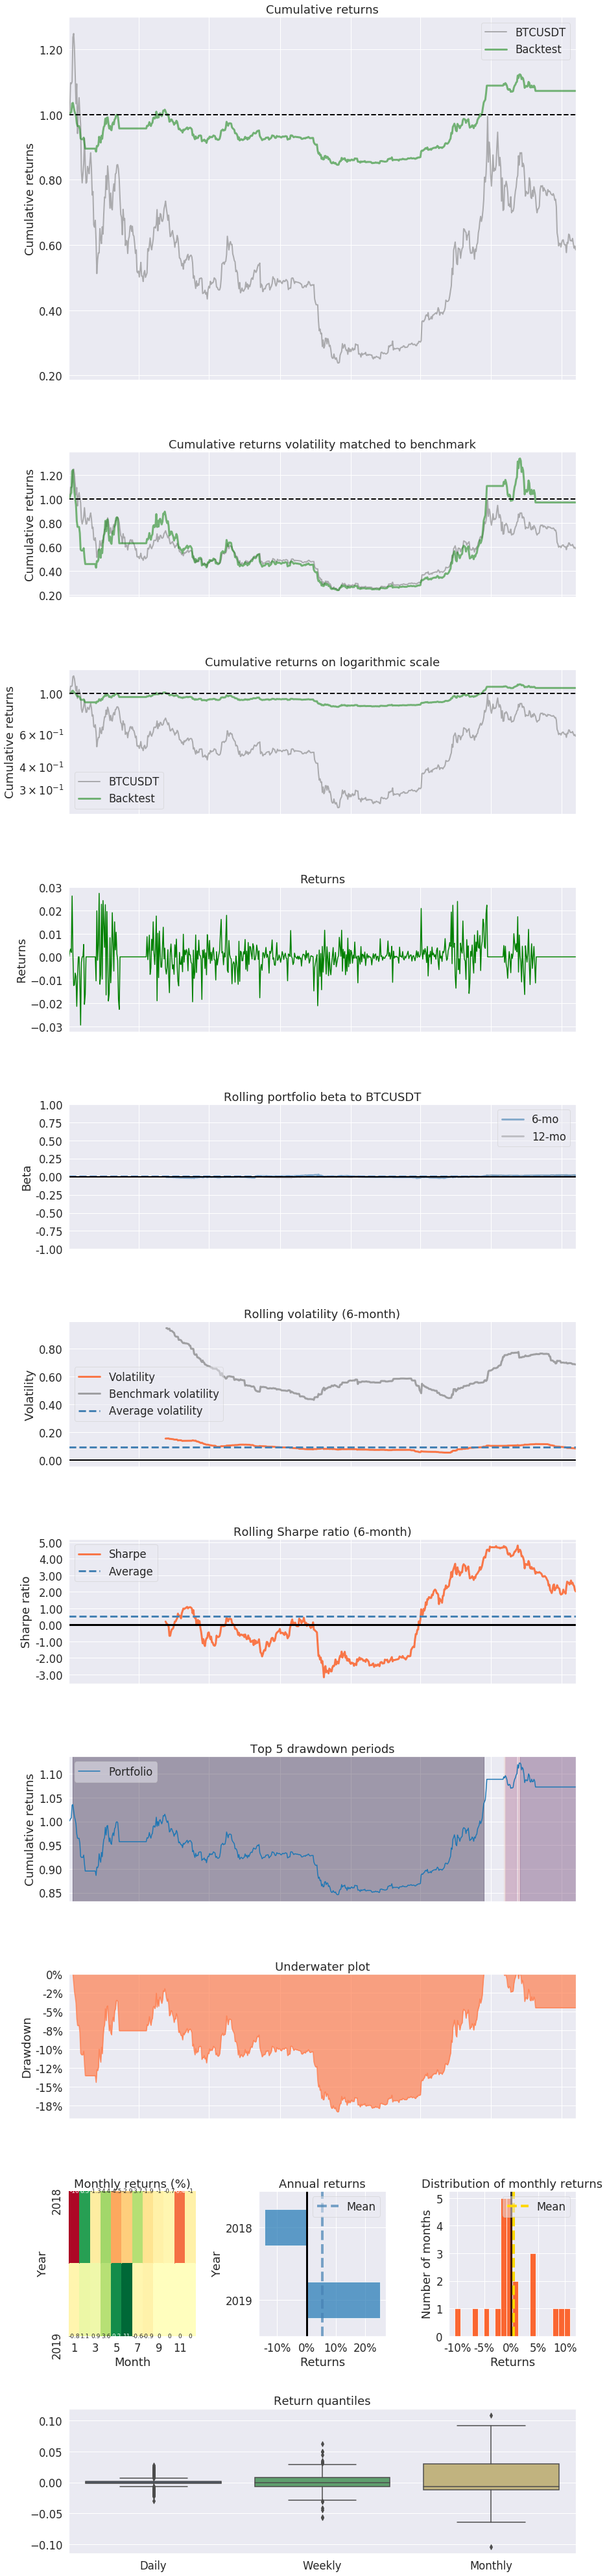

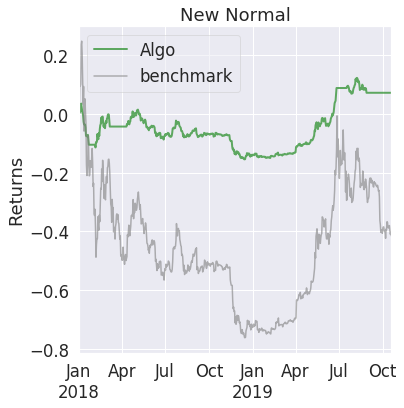

In [23]:
pf.create_full_tear_sheet(
        bench.Returns,
        #positions=positions,
        transactions=transactions,
        benchmark_rets=bench.BTCUSDT.pct_change(),
        #live_start_date='2019-01-01',
        )

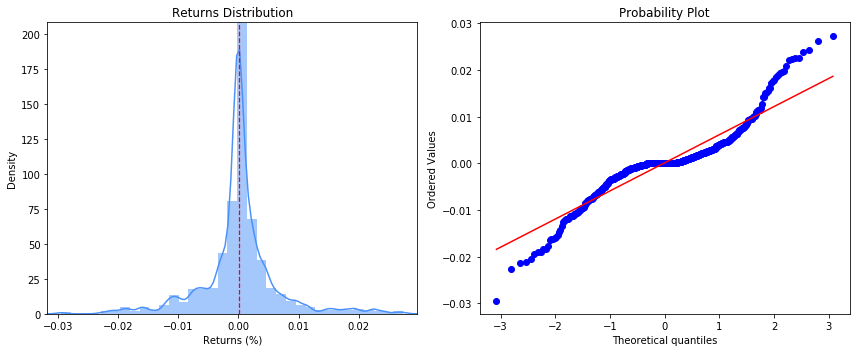

count    657.000000
mean       0.000127
std        0.006424
min       -0.029392
25%       -0.001455
50%        0.000000
75%        0.002097
max        0.027393
Name: Returns, dtype: float64

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(bench.Returns, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='BTC Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x= bench.Returns.mean(), color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(bench.Returns, plot=ax2)

plt.tight_layout()

plt.show();

bench.Returns.describe()

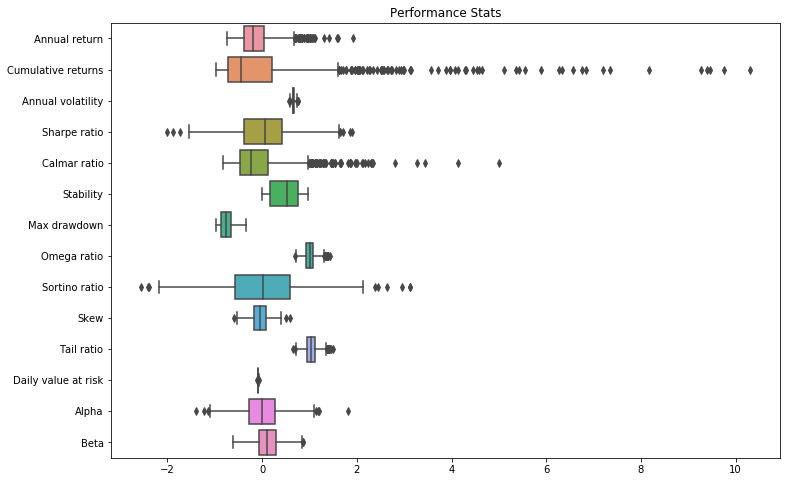

In [26]:
plt.figure(figsize=(12,8))
pf.plot_perf_stats(factor_returns=bench.Returns, returns=bench.BTCUSDT.pct_change())
plt.title('Performance Stats')
plt.show();